## Goal
To create a predictive model to get into top 30% of paticipants of the classical beginners Titanic challenge

### Objectives
1. Test different ML models
2. Choose and fine tune the most promissing model

### Data
The data consists of train and test samples of Titanic passengers with actual survival rate

### Loading and exploaring the data

In [133]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
df = pd.read_csv('train.csv')
df.head()
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


We assume that PassengerId, Name, Ticket # and Cabin do not have significant prognostic value so we can get rid of them. We will also drop Embarkment place and number of children per parent as those features showed minor value importance with preliminary xgb analysis.

In [3]:
df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Parch', 'Embarked'], inplace=True)

In [41]:
df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [42]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [5]:
# We impute Age missing values
df['Age'].fillna((df['Age'].mean()), inplace=True)
df['Age']=df['Age'].astype(int) # converting Age into int
df['Fare']=df['Fare'].astype(int)

In [6]:
# Label categorical values
df['Sex'].replace(['female','male'],[0,1],inplace=True)
# df['Embarked'].replace(['S', 'C', 'Q'], [0,1,2], inplace=True)

### Data visualization

In [131]:
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/v8/9ljqp91d0pz2t93nf7r4kqjh0000gn/T/ipykernel_38322/3405741292.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(ax=ax)


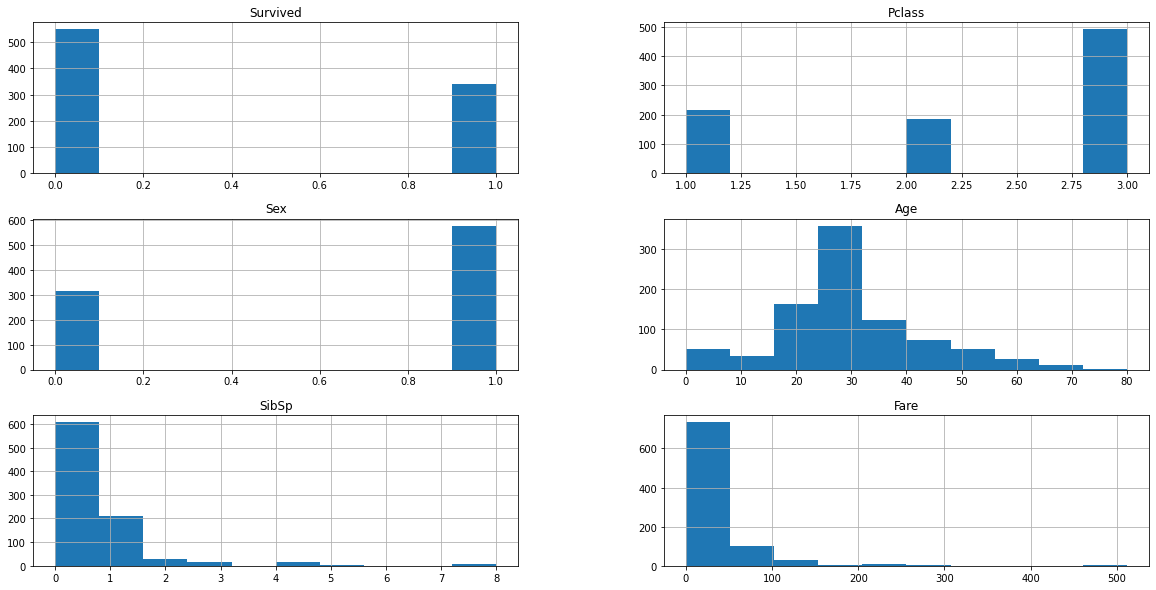

In [132]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
df.hist(ax=ax)
plt.show()

### Defining predictors and the target value

In [8]:
X=df.drop(['Survived'], axis=1)
y=df['Survived']

### Preparing the data for training

In [9]:
X=pd.get_dummies(X, columns=['Pclass', 'Sex'])

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.3,random_state=42)

In [134]:
### Standartize some of our data as some models will perform better with standartized data
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train[['Fare', 'Age', 'SibSp']]=ss.fit_transform(X_train[['Fare', 'Age', 'SibSp']])
X_val[['Fare', 'Age', 'SibSp']]=ss.transform(X_val[['Fare', 'Age', 'SibSp']])

In [13]:
# Import models zoo to test
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from tensorflow.keras import models
from tensorflow.keras import layers

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix #use accuracy_score as a base metrics

In [137]:
def logreg(X_train,y_train, X_val, y_val, Models):
    logreg = LogisticRegression()
    logreg.fit(X_train, y_train)
    y_pred = logreg.predict(X_val)
    Models['Logistic Regression'] = [accuracy_score(y_val, y_pred),confusion_matrix(y_val, y_pred)]
    return

def Nearest(X_train,y_train,X_val,y_val, Models):
    knn = KNeighborsClassifier(leaf_size=1, n_neighbors=7, p=1)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_val)
    Models['KNN'] = [accuracy_score(y_val,y_pred),confusion_matrix(y_val,y_pred)]

def bayes(X_train,y_train,X_val,y_val,Models):
    gaussian = GaussianNB()
    gaussian.fit(X_train, y_train)
    y_pred = gaussian.predict(X_val)
    Models['G_Bayes'] = [accuracy_score(y_val,y_pred),confusion_matrix(y_val,y_pred)]
    return

def bayes1(X_train,y_train,X_val,y_val,Models):
    bernoulli = BernoulliNB()
    bernoulli.fit(X_train, y_train)
    y_pred = bernoulli.predict(X_val)
    Models['B_Bayes'] = [accuracy_score(y_val,y_pred),confusion_matrix(y_val,y_pred)]
    return

def bayes2(X_train,y_train,X_val,y_val,Models):
    complement = ComplementNB()
    complement.fit(X_train, y_train)
    y_pred = complement.predict(X_val)
    Models['C_Bayes'] = [accuracy_score(y_val,y_pred),confusion_matrix(y_val,y_pred)]
    return

def bayes3(X_train,y_train,X_val,y_val,Models):
    multinomial = MultinomialNB()
    multinomial.fit(X_train, y_train)
    y_pred = multinomial.predict(X_val)
    Models['M_Bayes'] = [accuracy_score(y_val,y_pred),confusion_matrix(y_val,y_pred)]
    return

def linSVC(X_train,y_train,X_val,y_val,Models):
    linear_svc = LinearSVC()
    linear_svc.fit(X_train, y_train)
    y_pred = linear_svc.predict(X_val)
    Models['SVM'] = [accuracy_score(y_val,y_pred),confusion_matrix(y_val, y_pred)]
    return

def percep(X_train,y_train,X_val,y_val,Models):
    perceptron = Perceptron(max_iter = 1000, tol = 0.001)
    perceptron.fit(X_train, y_train)
    y_pred = perceptron.predict(X_val)
    Models['Perceptron'] = [accuracy_score(y_val,y_pred),confusion_matrix(y_val, y_pred)]
    return

def ranfor(X_train,y_train,X_val,y_val,Models):
    randomfor = RandomForestClassifier(max_features="sqrt",
                                       n_estimators = 700,
                                       max_depth = None,
                                       n_jobs=-1
                                      )
    randomfor.fit(X_train,y_train)
    y_pred = randomfor.predict(X_val)
    Models['Random Forests'] = [accuracy_score(y_val, y_pred),confusion_matrix(y_val, y_pred)]
    return

def dec_tree(X_train,y_train,X_val,y_val,Models):
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_train, y_train)
    y_pred = decision_tree.predict(X_val)
    Models['Decision Tree'] = [accuracy_score(y_val, y_pred),confusion_matrix(y_val,y_pred)]
    return

def SGDClass(X_train,y_train,X_val,y_val,Models):
    sgd = SGDClassifier(max_iter = 1000, tol = 0.001)
    sgd.fit(X_train, y_train)
    y_pred = sgd.predict(X_val)
    Models['SGD Classifier'] = [accuracy_score(y_val, y_pred),confusion_matrix(y_val, y_pred)]
    return


def XGB(X_train,y_train,X_val,y_val,Models):
    D_train = xgb.DMatrix(X_train, label=y_train)
    D_test = xgb.DMatrix(X_val, label=y_val)
    param = {
        'eta': 0.3, 
    'max_depth': 3,  
    'objective': 'multi:softprob',
    'num_class': 2}
    steps = 20
    xgb_model = xgb.train(param, D_train, steps)
#     xgb_model = xgb.train(D_train)
    preds = xgb_model.predict(D_test)
    best_preds = np.asarray([np.argmax(line) for line in preds])
    Models['XGB'] = [accuracy_score(y_val, best_preds)]

def DNN(X_train,y_train,X_val,y_val,Models):
    model= models.Sequential()
    model.add(layers.Dense(256, activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=0)
    
    Models['DNN'] = [model.evaluate(X_val, y_val, verbose=0)[1]]
    

In [43]:
def run_all_and_Plot(X_train,y_train,X_val,y_val):
    
    Models = dict()
    logreg(X_train,y_train,X_val,y_val, Models)
    Nearest(X_train,y_train,X_val,y_val, Models)
    bayes(X_train,y_train,X_val,y_val, Models)
    bayes1(X_train,y_train,X_val,y_val, Models)
#     bayes2(X_train,y_train,X_val,y_val, Models) # turned off as these models are unable to work with negative values (after standrtization)
#     bayes3(X_train,y_train,X_val,y_val, Models)
    linSVC(X_train,y_train,X_val,y_val, Models)
    percep(X_train,y_train,X_val,y_val, Models)
    ranfor(X_train,y_train,X_val,y_val, Models)
    dec_tree(X_train,y_train,X_val,y_val, Models)
    SGDClass(X_train,y_train,X_val,y_val, Models)
    XGB(X_train,y_train,X_val,y_val, Models)
    DNN(X_train,y_train,X_val,y_val, Models)
    
    return Models



In [17]:
def plot_bar(dict):
    labels = tuple(dict.keys())
    y_pos = np.arange(len(labels))
    values = [dict[n][0] for n in dict]
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, labels,rotation='vertical')
    plt.ylabel('accuracy')
    plt.title('Accuracy of different models')
    plt.show()


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[14:32:34] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Logistic Regression 0.81
KNN 0.77
G_Bayes 0.79
B_Bayes 0.8
SVM 0.79
Perceptron 0.8
Random Forests 0.81
Decision Tree 0.78
SGD Classifier 0.77
XGB 0.83
DNN 0.81


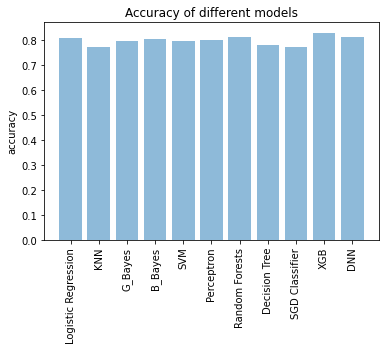

In [138]:

accuracies = run_all_and_Plot(X_train, y_train, X_val, y_val)
CompareAll = dict()
CompareAll['Baseline'] = accuracies
for key,val in accuracies.items():
    print(str(key) +' '+ str(round(val[0],2)))
plot_bar(accuracies)

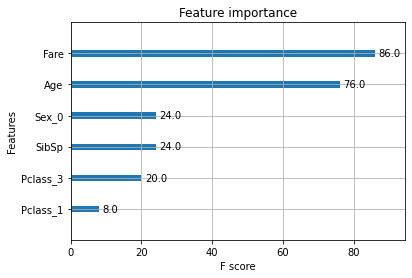

In [21]:
xgb.plot_importance(xgb_model)
plt.show()

### Logistic Regression model finetuning

In [139]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import decomposition

In [116]:
pca = decomposition.PCA()
logreg = LogisticRegression()

In [117]:
pipe = Pipeline(steps=[#('std_slc', std_slc),
                           ('pca', pca),
                           ('logreg', logreg)])

In [118]:
n_components = list(range(1,X_train.shape[1]+1,1))

In [119]:
C = np.logspace(-4, 4, 50)
penalty = ['l1', 'l2']

In [120]:
parameters = dict(pca__n_components=n_components,
                      logreg__C=C,
                      logreg__penalty=penalty)

In [121]:
clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(X_train, y_train)

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warni

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan 0.6292129  0.6292129  0.6292129  0.6292129
 0.6292129  0.6292129  0.6292129  0.6292129         nan        nan
        nan        nan        nan        nan        nan        nan
 0.6292129  0.6292129  0.6292129  0.6292129  0.6292129  0.6292129
 0.6292129  0.6292129         nan        nan        nan        nan
        nan        nan        nan        nan 0.6292129  0.6292129
 0.6292129  0.6292129  0.6292129  0.6292129  0.6292129  0.6292129
        nan        nan        nan        nan        nan        nan
        nan        nan 0.6292129  0.6292129  0.6292129  0.6292129
 0.6292129  0.6292129  0.6292129  0.6292129         nan        nan
        nan        nan        nan        nan        nan        nan
 0.6292129  0.6292129  0.6292129  0.6292129  0.6292129  0.6292

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'logreg__C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-02, 2.81176...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'logreg__penalty': ['l1', 'l2'],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8]})

In [122]:
print('Best Penalty:', clf_GS.best_estimator_.get_params()['logreg__penalty'])
print('Best C:', clf_GS.best_estimator_.get_params()['logreg__C'])
print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
print(); print(clf_GS.best_estimator_.get_params()['logreg'])

Best Penalty: l2
Best C: 0.02811768697974228
Best Number Of Components: 6

LogisticRegression(C=0.02811768697974228)


In [152]:
logreg = LogisticRegression(penalty='l2', C=0.0281176, solver='lbfgs', random_state=42)

In [153]:
logreg.fit(X_train, y_train)

LogisticRegression(C=0.0281176, random_state=42)

In [154]:
y_pred=logreg.predict(X_val)

In [126]:
accuracy_score(y_val, y_pred)

0.8171641791044776

### Preparing the test data

In [143]:
X_test = pd.read_csv('test.csv')

In [144]:
test_id=X_test['PassengerId']

In [145]:
X_test.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Parch', 'Embarked'], inplace=True)

In [146]:
X_test['Age'].fillna((X_test['Age'].mean()), inplace=True)
X_test['Age']=X_test['Age'].astype(int) # converting Age into int
X_test['Sex'].replace(['female','male'],[0,1],inplace=True)
X_test['Fare'].fillna((X_test['Fare'].mean()), inplace=True)
X_test['Fare']=X_test['Fare'].astype(int)

In [147]:
X_test=pd.get_dummies(X_test, columns=['Pclass', 'Sex'])

In [148]:
X_test[['Fare', 'Age', 'SibSp']]=ss.transform(X_test[['Fare', 'Age', 'SibSp']])

In [72]:
X_test.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Embarked_0,Embarked_1,Embarked_2
0,0.369258,-0.474161,-0.479327,-0.478747,0,0,1,0,1,0,0,1
1,1.367461,0.348687,-0.479327,-0.478747,0,0,1,1,0,1,0,0
2,2.519235,-0.474161,-0.479327,-0.439533,0,1,0,0,1,0,0,1
3,-0.168237,-0.474161,-0.479327,-0.459140,0,0,1,0,1,1,0,0
4,-0.552161,0.348687,0.759763,-0.380713,0,0,1,1,0,1,0,0


In [155]:
# predicting the values
submission = logreg.predict(X_test)

In [156]:
# write predictions to submission form
to_send= pd.DataFrame({'PassengerId': test_id,
                       'Survived': submission})
to_send.to_csv('submission2.csv', index=False)

In [157]:
to_send.head() # check the data

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
